In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
from datetime import datetime
import os
import gmaps
import seaborn as sns
import re

# Google API Key
from config import gkey

## Store County Health Rankings Excel file results into DataFrame

* Load the excel file imported from https://www.countyhealthrankings.org/app/texas/2019/measure/outcomes/144/description?sort=desc-2

In [2]:
path = "data/2019 County Health Rankings Texas Data - v1_0.xls"

# Get the available sheets in the excel file and put into a list
sheets = pd.ExcelFile(path).sheet_names
print(sheets)

['Introduction', 'Outcomes & Factors Rankings', 'Outcomes & Factors SubRankings', 'Ranked Measure Data', 'Additional Measure Data', 'Ranked Measure Sources & Years', 'Addtl Measure Sources & Years']


## Read in the Ranked Measure Data sheet eliminating columns and extra headers
* Make a list of available columns to decide what we don't want
* Formulate a regex expression to match unwanted columns
* Create a list of only wanted columns to be used for the usecols argument
* Set county to be the index
* Eliminate any row without a county name

In [3]:
# Get the 'Ranked Measure Data' sheet using the sheets list above and rejecting the top header row
rmd = pd.read_excel(path, header=[1], sheet_name=sheets[3])

# View the columns and decide what we don't want
col1 = [col for col in rmd.columns] 
col1.sort()
col1

['# Alcohol-Impaired Driving Deaths',
 '# Associations',
 '# Chlamydia Cases',
 '# Dentists',
 '# Driving Deaths',
 '# Households',
 '# Injury Deaths',
 '# Mental Health Providers',
 '# Primary Care Physicians',
 '# Single-Parent Households',
 '# Some College',
 '# Unemployed',
 '# Uninsured',
 '# Workers who Drive Alone',
 '% Alcohol-Impaired',
 '% Children in Poverty',
 '% Children in Poverty (Black)',
 '% Children in Poverty (Hispanic)',
 '% Children in Poverty (White)',
 '% Drive Alone',
 '% Drive Alone (Black)',
 '% Drive Alone (Hispanic)',
 '% Drive Alone (White)',
 '% Excessive Drinking',
 '% Fair/Poor',
 '% LBW',
 '% LBW (Black)',
 '% LBW (Hispanic)',
 '% LBW (White)',
 '% Long Commute - Drives Alone',
 '% Obese',
 '% Physically Inactive',
 '% Screened',
 '% Screened (Black)',
 '% Screened (Hispanic)',
 '% Screened (White)',
 '% Severe Housing Problems',
 '% Single-Parent Households',
 '% Smokers',
 '% Some College',
 '% Unemployed',
 '% Uninsured',
 '% Vaccinated',
 '% Vaccina

In [4]:
# Create a regular expression to match unwanted columns
regex = '^Z|95|State|Unreliable'

# Use a list comprehension to make a list of columns that don't match the regex (a failed regex match returns 'None')
cols = [col for col in rmd.columns if re.match(regex,col) is None]

# Create a dataframe of the desired columns and set 'County' to the index
rmd_df = pd.read_excel(path, header=[1], sheet_name=sheets[3],usecols=cols)

# Drop any row that has NaN as County value
rmd_df = rmd_df[pd.notnull(rmd_df['County'])]
print(f'shape of rmd_df: {rmd_df.shape}')
rmd_df.head(1)

shape of rmd_df: (254, 87)


,FIPS,County,Years of Potential Life Lost Rate,YPLL Rate (Black),YPLL Rate (Hispanic),YPLL Rate (White),% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,% LBW,...,% Severe Housing Problems,Severe Housing Cost Burden,Overcrowding,Inadequate Facilities,% Drive Alone,% Drive Alone (Black),% Drive Alone (Hispanic),% Drive Alone (White),# Workers who Drive Alone,% Long Commute - Drives Alone
1,48001,Anderson,10272.949118,12962.159784,10880.315229,9971.540573,19.529585,3.92613,3.642847,7.249879,...,15.446669,10.453172,4.30236,1.224978,85.067105,82.663714,81.071311,86.307537,16036,26.8


## Read in the Additional Measure Data sheet eliminating columns and extra headers
* Make a list of available columns to decide what we don't want
* Formulate a regex expression to match unwanted columns
* Create a list of only wanted columns to be used for the usecols argument
* Set county to be the index
* Eliminate any row without a county name

In [5]:
# Get the 'Ranked Measure Data' sheet using the sheets list above and rejecting the top header row
amd = pd.read_excel(path, header=[1], sheet_name=sheets[4])

# View the columns and decide what we don't want
[print(col) for col in amd.columns] 

FIPS
State
County
Life Expectancy
95% CI - Low
95% CI - High
Life Expectancy (Black)
Life Expectancy (Hispanic)
Life Expectancy (White)
# Deaths
Age-Adjusted Mortality
95% CI - Low.1
95% CI - High.1
Age-Adjusted Mortality (Black)
Age-Adjusted Mortality (Hispanic)
Age-Adjusted Mortality (White)
# Deaths.1
Child Mortality Rate
95% CI - Low.2
95% CI - High.2
Child Mortality Rate (Black)
Child Mortality Rate (Hispanic)
Child Mortality Rate (White)
# Deaths.2
Infant Mortality Rate
95% CI - Low.3
95% CI - High.3
Infant Mortality Rate (Black)
Infant Mortality Rate (Hispanic)
Infant Mortality Rate (White)
% Frequent Physical Distress
95% CI - Low.4
95% CI - High.4
% Frequent Mental Distress
95% CI - Low.5
95% CI - High.5
% Diabetic
95% CI - Low.6
95% CI - High.6
# HIV Cases
HIV Prevalence Rate
# Food Insecure
% Food Insecure
# Limited Access
% Limited Access
# Drug Overdose Deaths
Drug Overdose Mortality Rate
# Motor Vehicle Deaths
MV Mortality Rate
95% CI - Low.7
95% CI - High.7
% Insufficien

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
# Create a regular expression to match unwanted columns
regex = '^Z|95|State|Unreliable'

# Use a list comprehension to make a list of columns that don't match the regex (a failed regex match returns 'None')
cols = [col for col in amd.columns if re.match(regex,col) is None]

# Create a dataframe of the desired columns and set 'County' to the index
amd_df = pd.read_excel(path, header=[1], sheet_name=sheets[4],usecols=cols)

# Drop any row that has Nan as County value
amd_df = amd_df[pd.notnull(amd_df['County'])]
print(f'shape of rmd_df: {amd_df.shape}')
amd_df.head(1)

shape of rmd_df: (254, 76)


,FIPS,County,Life Expectancy,Life Expectancy (Black),Life Expectancy (Hispanic),Life Expectancy (White),# Deaths,Age-Adjusted Mortality,Age-Adjusted Mortality (Black),Age-Adjusted Mortality (Hispanic),...,% Native Hawaiian/Other Pacific Islander,# Hispanic,% Hispanic,# Non-Hispanic White,% Non-Hispanic White,# Not Proficient in English,% Not Proficient in English,% Female,# Rural,% Rural
1,48001,Anderson,73.773772,70.933226,82.901506,74.097055,1075.0,544.0,721.905041,597.224357,...,0.143745,10287,17.815763,34140,59.126098,1488,2.715874,39.06756,39204,67.063533


In [7]:
# Merge the rmd and amd dataframes using inner join on County column (index)
merged_df = pd.merge(rmd_df,amd_df, how='inner', on='County')
print(f'shape of merged_df: {merged_df.shape}')
#merged_df.head(1)

shape of merged_df: (254, 162)


In [8]:
# View the columns that end in '_x' or '_y'
regex2 = '.*_x$|.*_y$'
[print(col) for col in merged_df.columns if re.match(regex2,col) is not None] 

FIPS_x
# Uninsured_x
% Uninsured_x
Population_x
FIPS_y
# Uninsured_y
% Uninsured_y
Population_y


[None, None, None, None, None, None, None, None]

In [9]:
# Drop the duplicate _y columns
regex3 = '.*_y$'
merged_df.drop([col for col in merged_df.columns if re.match(regex3,col) is not None],axis=1, inplace=True)
print(merged_df.shape)

(254, 158)


In [10]:
# Rename the columns to eliminate the '_x' leftover from the join
merged_df.rename(columns = {'FIPS_x':'FIPS',\
                                        '# Uninsured_x':'# Uninsured',\
                                        '% Uninsured_x':'% Uninsured',\
                                        'Population_x':'Population'},\
                                         inplace=True)
#merged_df.columns
# View the columns that end in '_x' or '_y'
regex2 = '.*_x$|.*_y$'
[print(col) for col in merged_df.columns if re.match(regex2,col) is not None] 

[]

## Store NCHS Urban Rural Classification System Excel file results into DataFrame

* Load the excel file imported from https://www.cdc.gov/nchs/data_access/urban_rural.htm#Data_Files_and_Documentation
* No description or label was given in the 'NCHS URCS' - only numbers 1-6. Reading the file documentation gave this information, so an excel sheet was created and a VLOOKUP mapped the names and descriptions to the classification numbers. The result excel file will be imported and joined to the merged_df

In [11]:
path2 = 'data/NCHS Urban Rural Classification System.xlsx'

# Get the available sheets in the excel file and put into a list
sheets2 = pd.ExcelFile(path2).sheet_names
print(sheets2)

['URCS', 'Legend']


In [12]:
# Get the 'URCS' sheet using the sheets list above and rejecting the top header row
cs = pd.read_excel(path2)
cs.columns
cs.head(1)


,FIPS code,State Abr.,County name,CBSA title,CBSA 2012 pop,County 2012 pop,2013 code,2006 code,1990-based code,URCS,URCS Name,URCS description
0,1073,AL,Jefferson County,"Birmingham-Hoover, AL",1136650,660009,1,1,3,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m..."


In [13]:
# Get the 'URCS' sheet using the columns list above
urcs = pd.read_excel(path2,usecols=['FIPS code','URCS','URCS Name','URCS description'],index_col=0)
print(f'shape of urcs: {urcs.shape}')


shape of urcs: (3149, 3)


In [14]:
# Drop any row that has Nan as an index value
urcs = urcs.loc[urcs.index.dropna()]
print(f'shape of urcs: {urcs.shape}')

shape of urcs: (3149, 3)


In [15]:
# Check that all FIPS in the merged_df are in the urcs.index (urcs index has ALL counties in USA not just Texas)
print(f"merged_df FIPS:{[mips for mips in merged_df['FIPS'] if mips not in urcs.index]} not found in urcs.index")
#print(f'urcs county:{[county for county in urcs.index if county not in merged_df["FIPS"]]} not found in merged_df.index')

merged_df FIPS:[] not found in urcs.index


In [16]:
# Rename the index 'FIPS code' to FIPS
urcs.rename_axis('FIPS', axis=0, inplace=True)
urcs.head()

,URCS,URCS Name,URCS description
FIPS,,,
1073,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m..."
4013,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m..."
6001,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m..."
6037,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m..."
6059,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m..."


# Merge the NCHS URCS data with the merged_df

In [17]:
all_df = pd.merge(urcs,merged_df, how='inner', on='FIPS')

#print(all_df.shape)
all_df.head(5)

,FIPS,URCS,URCS Name,URCS description,County,Years of Potential Life Lost Rate,YPLL Rate (Black),YPLL Rate (Hispanic),YPLL Rate (White),% Fair/Poor,...,% Native Hawaiian/Other Pacific Islander,# Hispanic,% Hispanic,# Non-Hispanic White,% Non-Hispanic White,# Not Proficient in English,% Not Proficient in English,% Female,# Rural,% Rural
0,48029,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m...",Bexar,6930.930981,9500.237875,6729.699925,6981.542280,23.789874,...,0.221691,1181315,60.314933,543068,27.727668,104033,5.926969,50.634542,77835,4.539085
1,48085,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m...",Collin,4160.034276,5490.145240,3264.642731,4560.990605,13.741809,...,0.093337,148440,15.309359,555608,57.302628,33154,3.876455,50.806773,41016,5.242727
2,48113,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m...",Dallas,6835.799747,10749.927745,4709.944753,6914.919059,19.476842,...,0.111529,1053358,40.232943,764217,29.189221,274261,11.633069,50.681474,16300,0.688304
3,48201,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m...",Harris,6591.278158,10945.592599,4844.046605,6787.718494,18.177992,...,0.124952,1998479,42.950518,1381864,29.698473,491301,11.765612,50.278531,49653,1.213280
4,48439,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m...",Tarrant,6357.035604,8887.576618,4541.816106,6752.814843,15.933967,...,0.241960,593452,28.885822,962516,46.849730,116369,6.323151,51.048467,23304,1.288201


In [18]:
multi_df = all_df.set_index(['URCS','URCS Name','County'])
multi_df = multi_df.sort_index()

print(multi_df.shape)
multi_df.head(50)

(254, 158)


FIPS  \
URCS  URCS Name    County               
Rural Micropolitan Anderson     48001   
                   Andrews      48003   
                   Angelina     48005   
                   Bee          48025   
                   Brown        48049   
                   Calhoun      48057   
                   Cherokee     48073   
                   Cooke        48097   
                   Dawson       48115   
                   Deaf Smith   48117   
                   Erath        48143   
                   Gillespie    48171   
                   Glasscock    48173   
                   Gray         48179   
                   Hale         48189   
                   Harrison     48203   
                   Henderson    48213   
                   Hockley      48219   
                   Hopkins      48223   
                   Howard       48227   
                   Hutchinson   48233   
                   Jim Wells    48249   
                   Kenedy       48261   
                   Kerr         48265   
                   Kleberg      48273   
                   Lamar        48277   
                   Matagorda    48321   
                   Maverick     48323   
                   Moore        48341   
                   Nacogdoches  48347   
                   Navarro      48349   
                   Nolan        48353   
                   Palo Pinto   48363   
                   Reeves       48389   
                   Scurry       48415   
                   Starr        48427   
                   Titus        48449   
                   Trinity      48455   
                   Uvalde       48463   
                   Val Verde    48465   
                   Walker       48471   
                   Washington   48477   
                   Wharton      48481   
                   Wilbarger    48487   
                   Willacy      48489   
                   Zapata       48505   
      Noncore      Bailey       48017   
                   Baylor       48023   
                   Blanco       48031   
                   Borden       48033   

                                                                 URCS description  \
URCS  URCS Name    County                                                           
Rural Micropolitan Anderson            Counties in micropolitan statistical areas   
                   Andrews             Counties in micropolitan statistical areas   
                   Angelina            Counties in micropolitan statistical areas   
                   Bee                 Counties in micropolitan statistical areas   
                   Brown               Counties in micropolitan statistical areas   
                   Calhoun             Counties in micropolitan statistical areas   
                   Cherokee            Counties in micropolitan statistical areas   
                   Cooke               Counties in micropolitan statistical areas   
                   Dawson              Counties in micropolitan statistical areas   
                   Deaf Smith          Counties in micropolitan statistical areas   
                   Erath               Counties in micropolitan statistical areas   
                   Gillespie           Counties in micropolitan statistical areas   
                   Glasscock           Counties in micropolitan statistical areas   
                   Gray                Counties in micropolitan statistical areas   
                   Hale                Counties in micropolitan statistical areas   
                   Harrison            Counties in micropolitan statistical areas   
                   Henderson           Counties in micropolitan statistical areas   
                   Hockley             Counties in micropolitan statistical areas   
                   Hopkins             Counties in micropolitan statistical areas   
                   Howard              Counties in micropolitan statistical areas   
                   Hutchinson 

In [19]:
#idx = pd.IndexSlice
#rural_df = final_merged_df.loc[idx['Rural',:],:]
rural_df = multi_df.loc['Rural']
print(rural_df.shape)

(172, 158)


In [20]:
#urban_df = final_merged_df.loc[idx['Urban',:],:]
urban_df = multi_df.loc['Urban']
print(urban_df.shape)

(82, 158)


In [21]:
urban_df.head(3)

FIPS  \
URCS Name           County          
Large central metro Bexar   48029   
                    Collin  48085   
                    Dallas  48113   

                                                             URCS description  \
URCS Name           County                                                      
Large central metro Bexar   NCHS-defined "central" counties of MSAs of 1 m...   
                    Collin  NCHS-defined "central" counties of MSAs of 1 m...   
                    Dallas  NCHS-defined "central" counties of MSAs of 1 m...   

                            Years of Potential Life Lost Rate  \
URCS Name           County                                      
Large central metro Bexar                         6930.930981   
                    Collin                        4160.034276   
                    Dallas                        6835.799747   

                            YPLL Rate (Black)  YPLL Rate (Hispanic)  \
URCS Name           County                                            
Large central metro Bexar         9500.237875           6729.699925   
                    Collin        5490.145240           3264.642731   
                    Dallas       10749.927745           4709.944753   

                            YPLL Rate (White)  % Fair/Poor  \
URCS Name           County                                   
Large central metro Bexar         6981.542280    23.789874   
                    Collin        4560.990605    13.741809   
                    Dallas        6914.919059    19.476842   

                            Physically Unhealthy Days  \
URCS Name           County                              
Large central metro Bexar                    4.264237   
                    Collin                   2.910349   
                    Dallas                   3.450140   

                            Mentally Unhealthy Days     % LBW  ...  \
URCS Name           County                                     ...   
Large central metro Bexar                  3.789844  9.032323  ...   
                    Collin                 3.256196  7.772925  ...   
                    Dallas                 3.528078  8.499218  ...   

                            % Native Hawaiian/Other Pacific Islander  \
URCS Name           County                                             
Large central metro Bexar                                   0.221691   
                    Collin                                  0.093337   
                    Dallas                                  0.111529   

                            # Hispanic  % Hispanic  # Non-Hispanic White  \
URCS Name           County                                                 
Large central metro Bexar      1181315   60.314933                543068   
                    Collin      148440   15.309359                555608   
                    Dallas     1053358   40.232943                764217   

                            % Non-Hispanic White  # Not Proficient in English  \
URCS Name           County                                                      
Large central metro Bexar              27.727668                       104033   
                    Collin             57.302628                        33154   
                    Dallas             29.189221                       274261   

                            % Not Proficient in English   % Female  # Rural  \
URCS Name           County                                                    
Large central metro Bexar                      5.926969  50.634542    77835   
                    Collin                     3.876455  50.806773    41016   
                    Dallas                    11.633069  50.681474    16300   

                             % Rural  
URCS Name           County            
Large central metro Bexar   4.539085  
                    Collin  5.242727  
                    Dallas  0.688304  

[3 rows x 158 columns]

In [22]:
corr1 = multi_df.corr()

In [23]:
corr1.to_csv('Corr1.csv')

In [24]:
multi_df.to_csv('multi_df.csv')

In [25]:
corr1_spear = multi_df.corr(method='spearman')

In [26]:
corr1_spear.to_csv('Corr1_spear.csv')

# Age adjusted Mortality (Deaths/100k) for Everyone

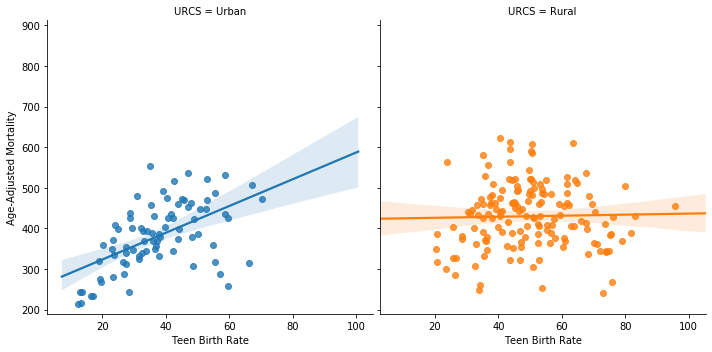

In [27]:
data_df = all_df
x_data = "Teen Birth Rate"
y_data = "Age-Adjusted Mortality"
color_col = "URCS"
split_col = "URCS"
x_label = x_data
y_label = y_data
ylim_min = data_df[y_data].min()*1.05
ylim_max = data_df[y_data].max()*1.05

g = sns.lmplot(x=x_data, y=y_data, data=all_df,\
           hue=color_col, col=split_col)

g = (g.set_axis_labels(x_label, y_label)
      .set(ylim=(ylim_min, ylim_max))
      .fig.subplots_adjust(wspace=.02))

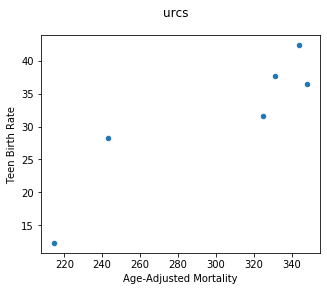

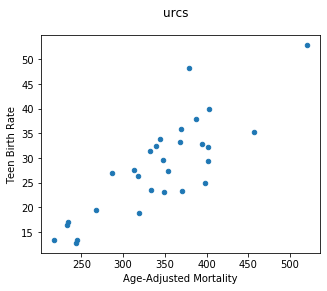

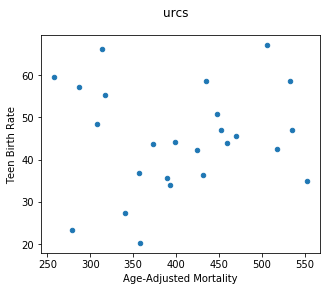

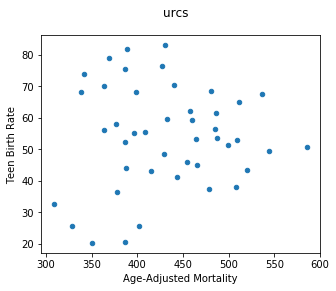

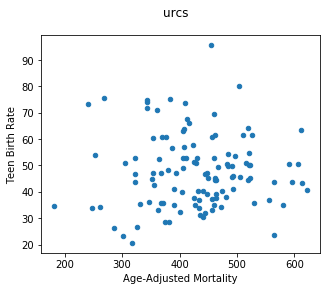

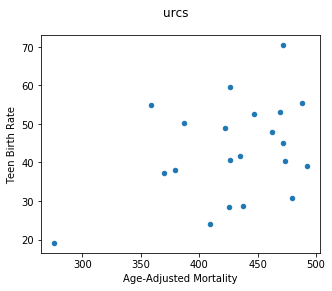

In [28]:
data_df.groupby('URCS Name').plot(kind='scatter', x="Age-Adjusted Mortality", y="Teen Birth Rate", title='urcs',subplots=True, figsize=(5,4), sharey=True)
# Add the linear regression equation and line to plot

plt.show()

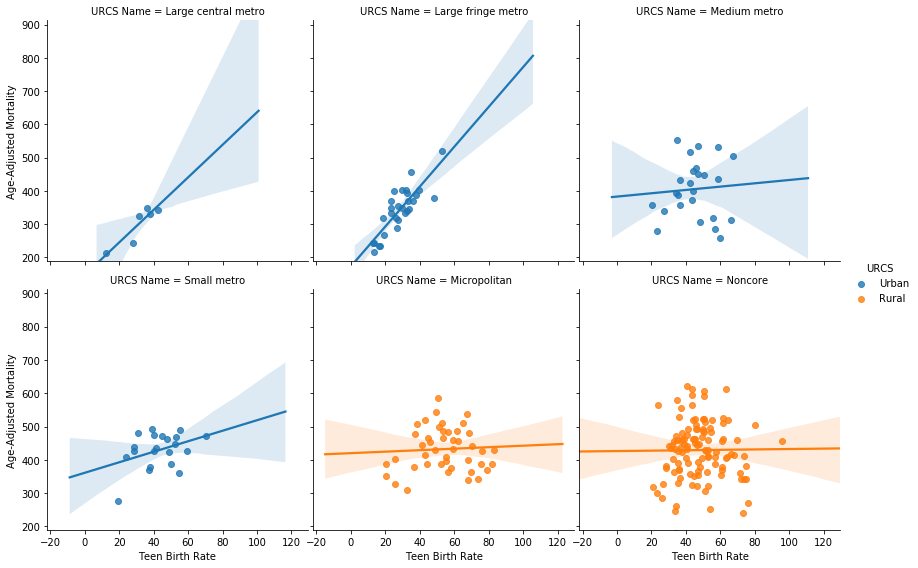

In [29]:
data_df = all_df
x_data = "Teen Birth Rate"
y_data = "Age-Adjusted Mortality"
color_col = "URCS"
split_col = "URCS Name"
x_label = x_data
y_label = y_data
ylim_min = data_df[y_data].min()*1.05
ylim_max = data_df[y_data].max()*1.05

g = sns.lmplot(x=x_data, y=y_data, data=all_df,\
           hue=color_col, col=split_col,col_wrap=3,height=4)

g = (g.set_axis_labels(x_label, y_label)
      .set(ylim=(ylim_min, ylim_max))
      .fig.subplots_adjust(wspace=.02))

# Age adjusted Mortality (Deaths/100k) for Whites

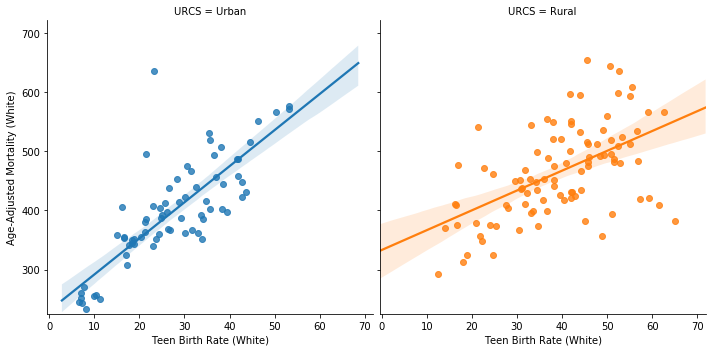

In [30]:
data_df = all_df
x_data = "Teen Birth Rate (White)"
y_data = "Age-Adjusted Mortality (White)"
color_col = "URCS"
split_col = "URCS"
x_label = x_data
y_label = y_data
ylim_min = data_df[y_data].min()*1.05
ylim_max = data_df[y_data].max()*1.05

g = sns.lmplot(x=x_data, y=y_data, data=all_df,\
           hue=color_col, col=split_col)

g = (g.set_axis_labels(x_label, y_label)
      .set(ylim=(ylim_min, ylim_max))
      .fig.subplots_adjust(wspace=.02))

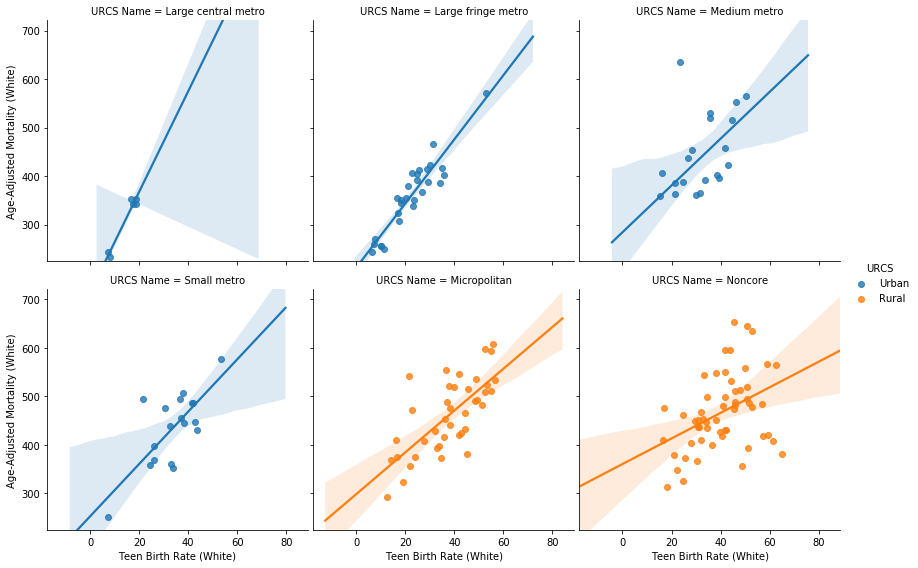

In [31]:
data_df = all_df
x_data = "Teen Birth Rate (White)"
y_data = "Age-Adjusted Mortality (White)"
color_col = "URCS"
split_col = "URCS Name"
x_label = x_data
y_label = y_data
ylim_min = data_df[y_data].min()*1.05
ylim_max = data_df[y_data].max()*1.05

g = sns.lmplot(x=x_data, y=y_data, data=all_df,\
           hue=color_col, col=split_col,col_wrap=3,height=4)

g = (g.set_axis_labels(x_label, y_label)
      .set(ylim=(ylim_min, ylim_max))
      .fig.subplots_adjust(wspace=.02))

# Age adjusted Mortality (Deaths/100k) for Blacks

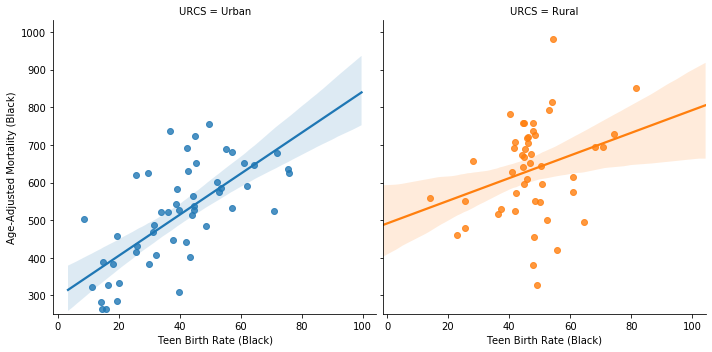

In [32]:
data_df = all_df
x_data = "Teen Birth Rate (Black)"
y_data = "Age-Adjusted Mortality (Black)"
color_col = "URCS"
split_col = "URCS"
x_label = x_data
y_label = y_data
ylim_min = data_df[y_data].min()*1.05
ylim_max = data_df[y_data].max()*1.05

g = sns.lmplot(x=x_data, y=y_data, data=all_df,\
           hue=color_col, col=split_col)

g = (g.set_axis_labels(x_label, y_label)
      .set(ylim=(ylim_min, ylim_max))
      .fig.subplots_adjust(wspace=.02))

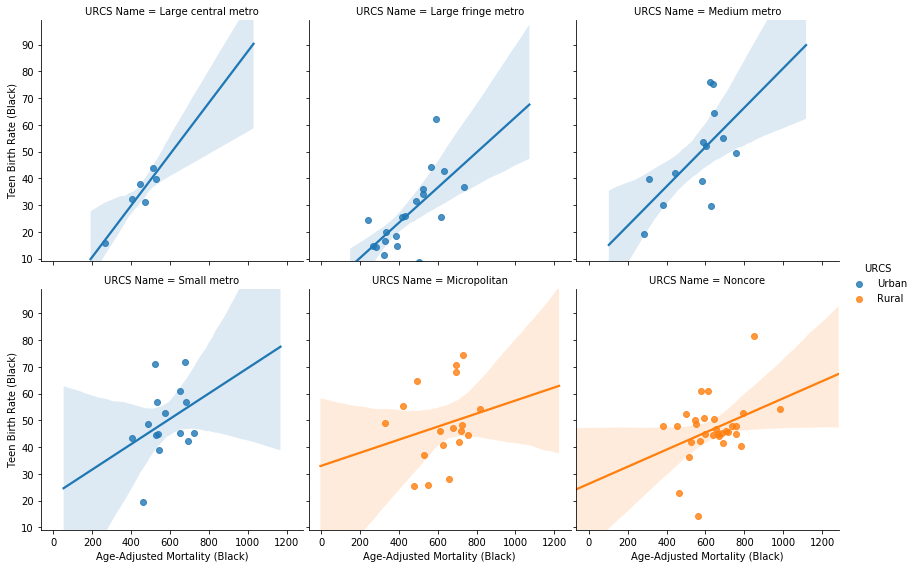

In [33]:
data_df = all_df
x_data = "Age-Adjusted Mortality (Black)"
y_data = "Teen Birth Rate (Black)"
color_col = "URCS"
split_col = "URCS Name"
x_label = x_data
y_label = y_data
ylim_min = data_df[y_data].min()*1.05
ylim_max = data_df[y_data].max()*1.05

g = sns.lmplot(x=x_data, y=y_data, data=all_df,\
           hue=color_col, col=split_col,col_wrap=3,height=4)

g = (g.set_axis_labels(x_label, y_label)
      .set(ylim=(ylim_min, ylim_max))
      .fig.subplots_adjust(wspace=.02))

# Age adjusted Mortality (Deaths/100k) for Hispanics

ylim min:143.4965179305, ylim max:641.7217326765001


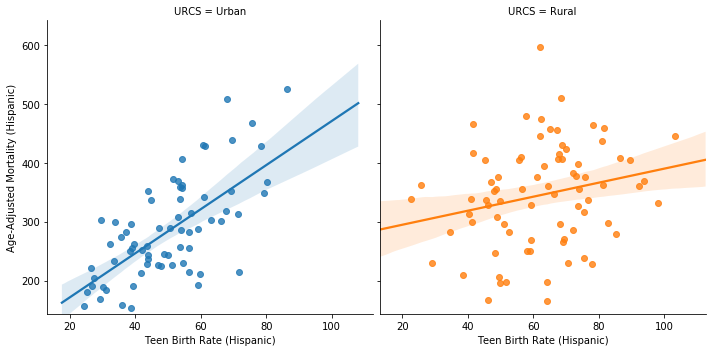

In [34]:
data_df = all_df
x_data = "Teen Birth Rate (Hispanic)"
y_data = "Age-Adjusted Mortality (Hispanic)"
color_col = "URCS"
split_col = "URCS"
x_label = x_data
y_label = y_data
ylim_min = data_df[y_data].min()*1.05
ylim_max = data_df[y_data].max()*1.05
print(f'ylim min:{ylim_min}, ylim max:{ylim_max}')
g = sns.lmplot(x=x_data, y=y_data, data=all_df,\
           hue=color_col, col=split_col)

g = (g.set_axis_labels(x_label, y_label)
      .set(ylim=(ylim_min, ylim_max))
      .fig.subplots_adjust(wspace=.02))

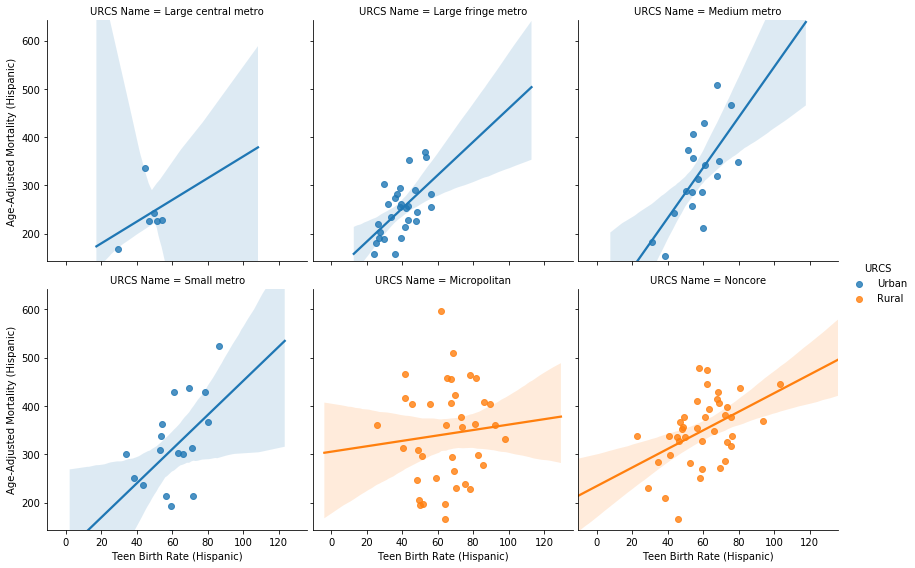

In [35]:
data_df = all_df
x_data = "Teen Birth Rate (Hispanic)"
y_data = "Age-Adjusted Mortality (Hispanic)"
color_col = "URCS"
split_col = "URCS Name"
x_label = x_data
y_label = y_data
ylim_min = data_df[y_data].min()*1.05
ylim_max = data_df[y_data].max()*1.05

g = sns.lmplot(x=x_data, y=y_data, data=all_df,\
           hue=color_col, col=split_col,col_wrap=3,height=4)

g = (g.set_axis_labels(x_label, y_label)
      .set(ylim=(ylim_min, ylim_max))
      .fig.subplots_adjust(wspace=.02))

### Physical Environment
#### Physical environment statistics includes (1) air and water quality, and (2) housing and transit

,Average Daily PM2.5,% Severe Housing Problems,Severe Housing Cost Burden,Overcrowding,Inadequate Facilities,% Drive Alone,% Long Commute - Drives Alone
URCS,,,,,,,
Rural,8.30,13.63,8.80,4.12,1.53,80.12,26.20
Urban,9.48,15.32,11.07,3.96,1.24,81.40,36.52


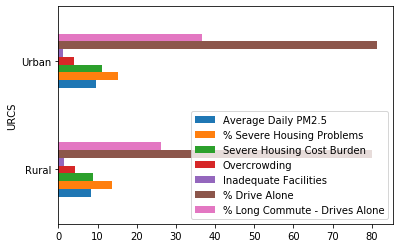

In [36]:
physic_env_u = all_df.groupby('URCS')["Average Daily PM2.5", "% Severe Housing Problems","Severe Housing Cost Burden", \
                                      "Overcrowding", "Inadequate Facilities", "% Drive Alone", \
                                      "% Long Commute - Drives Alone"].agg('mean').round(2)
physic_env_u.plot.barh()
physic_env_u

,Average Daily PM2.5,% Severe Housing Problems,Severe Housing Cost Burden,Overcrowding,Inadequate Facilities,% Drive Alone,% Long Commute - Drives Alone
URCS Name,,,,,,,
Large central metro,10.73,18.63,14.36,4.67,0.90,79.20,40.80
Large fringe metro,10.22,14.57,10.61,3.69,1.10,81.97,49.27
Medium metro,8.70,15.91,11.04,4.75,1.31,80.85,29.18
Micropolitan,8.70,15.58,10.08,5.02,1.53,81.13,23.37
Noncore,8.15,12.91,8.34,3.79,1.53,79.75,27.24
Small metro,9.02,14.75,10.81,3.24,1.44,81.85,26.88


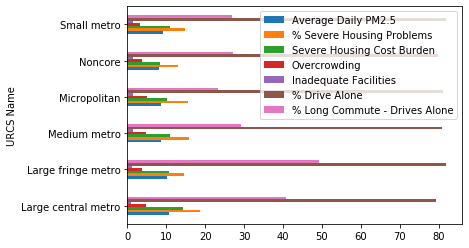

In [37]:
physic_env_un = all_df.groupby('URCS Name')["Average Daily PM2.5", "% Severe Housing Problems","Severe Housing Cost Burden",
                                      "Overcrowding", "Inadequate Facilities", "% Drive Alone", 
                                      "% Long Commute - Drives Alone"].agg('mean').round(2)
physic_env_un.plot.barh()
physic_env_un

### Social & Economic Factors
#### Education, employment, income, family & social support, community safety are Social Economic Factors.

,Graduation Rate,% Some College,% Unemployed,% Children in Poverty,Income Ratio,% Single-Parent Households,Association Rate,Violent Crime Rate,Injury Death Rate
URCS,,,,,,,,,
Rural,92.92,47.85,4.56,26.46,4.72,32.02,15.14,245.60,82.17
Urban,92.48,57.57,4.30,20.11,4.67,30.55,10.68,298.87,65.92


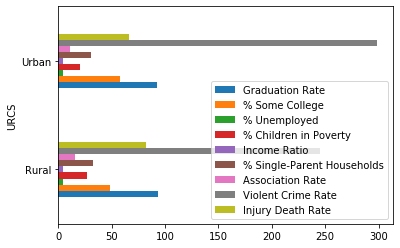

In [38]:
soc_eco_u = all_df.groupby('URCS')["Graduation Rate", "% Some College", "% Unemployed","% Children in Poverty","Income Ratio", 
                                "% Single-Parent Households","Association Rate","Violent Crime Rate","Injury Death Rate"].agg('mean').round(2)
soc_eco_u.plot.barh()
soc_eco_u 

,Graduation Rate,% Some College,% Unemployed,% Children in Poverty,Income Ratio,% Single-Parent Households,Association Rate,Violent Crime Rate,Injury Death Rate
URCS Name,,,,,,,,,
Large central metro,89.05,65.83,3.73,17.58,4.55,32.53,6.89,445.43,51.76
Large fringe metro,93.57,59.80,4.07,15.26,4.47,26.48,8.35,218.06,62.63
Medium metro,91.78,55.02,4.89,25.66,4.86,33.45,11.88,342.07,68.93
Micropolitan,90.70,47.98,4.92,26.35,4.90,33.37,11.51,344.33,70.19
Noncore,93.71,47.81,4.42,26.51,4.65,31.53,16.46,209.27,87.06
Small metro,92.79,55.28,4.06,20.88,4.76,32.07,13.44,316.33,71.22


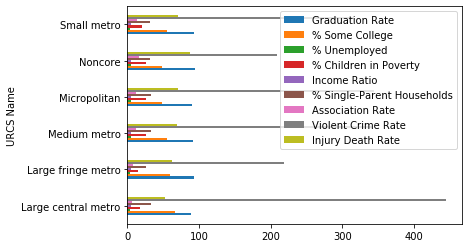

In [39]:
soc_eco_un = all_df.groupby('URCS Name')["Graduation Rate", "% Some College", "% Unemployed","% Children in Poverty","Income Ratio", 
                                "% Single-Parent Households","Association Rate","Violent Crime Rate","Injury Death Rate"].agg('mean').round(2)
soc_eco_un.plot.barh()
soc_eco_un 

,% Uninsured,PCP Rate,Dentist Rate,MHP Rate,Preventable Hosp. Rate,% Screened,% Vaccinated
URCS,,,,,,,
Rural,21.33,36.70,26.20,41.30,5334.32,31.19,32.14
Urban,17.93,49.14,40.67,76.11,5125.23,36.37,40.87


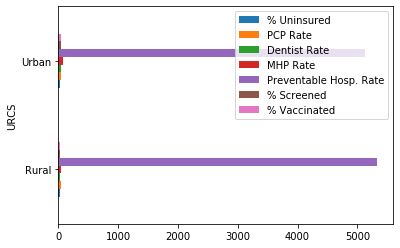

In [40]:
clinic_care_u = all_df.groupby('URCS')["% Uninsured","PCP Rate","Dentist Rate","MHP Rate","Preventable Hosp. Rate",
                                       "% Screened","% Vaccinated"].agg('mean').round(2)
clinic_care_u .plot.barh()
clinic_care_u  

,% Uninsured,PCP Rate,Dentist Rate,MHP Rate,Preventable Hosp. Rate,% Screened,% Vaccinated
URCS Name,,,,,,,
Large central metro,17.01,72.57,71.13,145.26,4682.33,38.83,46.33
Large fringe metro,16.72,45.74,39.39,62.79,5163.69,36.00,41.97
Medium metro,19.45,47.18,34.37,72.92,5201.28,35.20,37.72
Micropolitan,21.00,39.26,34.89,57.84,5962.11,32.71,37.13
Noncore,21.45,35.65,22.79,33.66,5102.76,30.64,30.29
Small metro,18.05,49.11,40.32,78.37,5108.91,37.50,41.50


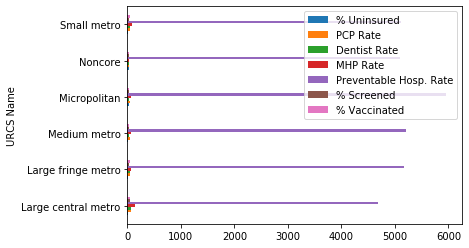

In [41]:
clinic_care_un = all_df.groupby('URCS Name')["% Uninsured","PCP Rate","Dentist Rate","MHP Rate","Preventable Hosp. Rate",
                                       "% Screened","% Vaccinated"].agg('mean').round(2)
clinic_care_un .plot.barh()
clinic_care_un  

,Years of Potential Life Lost Rate,% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,% LBW
URCS,,,,,
Rural,8814.95,20.59,3.89,3.68,8.04
Urban,7674.86,18.09,3.64,3.57,8.21


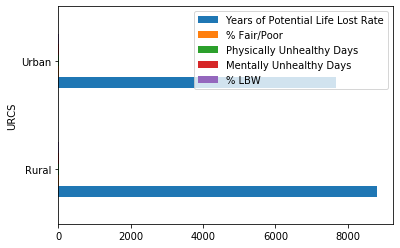

In [42]:
hlth_bhv_u = all_df.groupby('URCS')["Years of Potential Life Lost Rate","% Fair/Poor","Physically Unhealthy Days",
                                         "Mentally Unhealthy Days","% LBW"].agg('mean').round(2)
hlth_bhv_u .plot.barh()
hlth_bhv_u

,Years of Potential Life Lost Rate,% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,% LBW
URCS Name,,,,,
Large central metro,5920.73,17.51,3.50,3.50,8.32
Large fringe metro,6912.23,16.21,3.44,3.45,7.87
Medium metro,8134.37,20.96,3.93,3.72,8.65
Micropolitan,8467.09,22.26,4.02,3.72,8.20
Noncore,8968.01,19.97,3.85,3.66,7.97
Small metro,8747.82,17.45,3.63,3.58,8.12


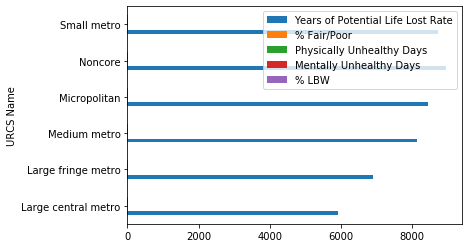

In [43]:
hlth_bhv_un = all_df.groupby('URCS Name')["Years of Potential Life Lost Rate","% Fair/Poor","Physically Unhealthy Days",
                                         "Mentally Unhealthy Days","% LBW"].agg('mean').round(2)
hlth_bhv_un .plot.barh()
hlth_bhv_un

,Age-Adjusted Mortality,Age-Adjusted Mortality (Black),Age-Adjusted Mortality (Hispanic),Age-Adjusted Mortality (White)
URCS,,,,
Rural,433.87,634.83,348.64,465.38
Urban,381.24,511.03,284.54,396.16


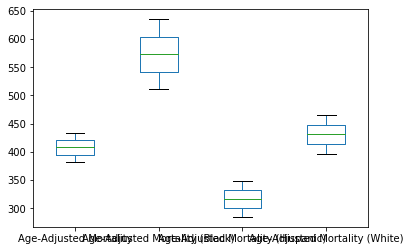

In [44]:
age_mortl_u = all_df.groupby('URCS')["Age-Adjusted Mortality","Age-Adjusted Mortality (Black)",
                                     "Age-Adjusted Mortality (Hispanic)","Age-Adjusted Mortality (White)"].agg('mean').round(2)

age_mortl_u.plot.box()
age_mortl_u

URCS
Rural    433.87
Urban    381.24
Name: Age-Adjusted Mortality, dtype: float64

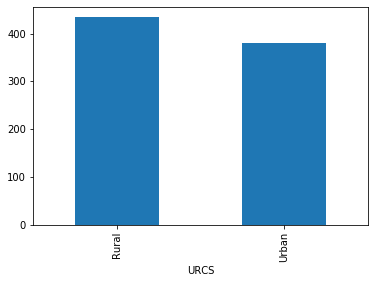

In [45]:
age_mortl_u = all_df.groupby('URCS')["Age-Adjusted Mortality"].agg('mean').round(2)

age_mortl_u.plot.bar()
age_mortl_u

In [46]:
age_mortl_std = all_df.groupby('URCS')["Age-Adjusted Mortality","Age-Adjusted Mortality (Black)",
                                     "Age-Adjusted Mortality (Hispanic)","Age-Adjusted Mortality (White)"].agg('std').round(2)
age_mortl_std

,Age-Adjusted Mortality,Age-Adjusted Mortality (Black),Age-Adjusted Mortality (Hispanic),Age-Adjusted Mortality (White)
URCS,,,,
Rural,88.08,126.59,88.48,81.01
Urban,81.59,136.02,85.55,89.26


,Age-Adjusted Mortality,Age-Adjusted Mortality (Black),Age-Adjusted Mortality (Hispanic),Age-Adjusted Mortality (White)
URCS Name,,,,
Large central metro,300.92,438.25,238.59,311.17
Large fringe metro,342.39,456.52,249.56,360.48
Medium metro,405.50,551.51,322.39,434.48
Micropolitan,432.04,623.38,342.61,462.27
Noncore,434.54,641.47,354.13,467.56
Small metro,428.97,577.75,314.32,435.27


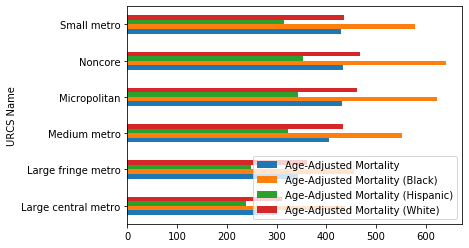

In [47]:
age_mortl_un = all_df.groupby('URCS Name')["Age-Adjusted Mortality","Age-Adjusted Mortality (Black)",
                                     "Age-Adjusted Mortality (Hispanic)","Age-Adjusted Mortality (White)"].agg('mean').round(2)

age_mortl_un.plot.barh()
age_mortl_un

In [48]:
age_mor_std = all_df.groupby('URCS Name')["Age-Adjusted Mortality","Age-Adjusted Mortality (Black)",
                                     "Age-Adjusted Mortality (Hispanic)","Age-Adjusted Mortality (White)"].agg('std').round(2)
age_mor_std

,Age-Adjusted Mortality,Age-Adjusted Mortality (Black),Age-Adjusted Mortality (Hispanic),Age-Adjusted Mortality (White)
URCS Name,,,,
Large central metro,57.26,95.81,54.38,56.70
Large fringe metro,69.95,138.33,55.99,73.98
Medium metro,86.25,147.80,92.58,93.41
Micropolitan,64.53,130.02,99.37,77.75
Noncore,95.56,126.23,78.05,83.80
Small metro,52.75,96.27,99.56,75.89


In [57]:
# Create DF that contains counties, URCS and URCS Name
#county_df = all_df [["URCS","URCS Name","County","FIPS","Age-Adjusted Mortality"]]
top_df = all_df.nsmallest(5, ['Age-Adjusted Mortality'])
top_1df = top_df[["URCS","URCS Name", "County", "Age-Adjusted Mortality"]]
print('The top five counties: ')
print (top_1df)
#county_df = county_df.loc[county_df['Age-Adjusted Mortality']>450]
#print(f'county_df.shape: {county_df.shape}')

The top five counties: 
      URCS            URCS Name      County  Age-Adjusted Mortality
185  Rural              Noncore  Jeff Davis                   180.5
1    Urban  Large central metro      Collin                   214.4
16   Urban   Large fringe metro   Fort Bend                   216.9
14   Urban   Large fringe metro      Denton                   233.3
32   Urban   Large fringe metro  Williamson                   233.5


In [61]:
# create a params dict that will be updated with county each iteration
params = {"key": gkey}

# Loop through the DF and run a lat/long search for each county
for index, row in top_1df.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"

    county = row['County']
    state = "Texas"

    # update address key value
    params['address'] = f"{county} county,{state}"

    # make request
    county_lat_lng = requests.get(base_url, params=params)
      
    # convert to json
    county_lat_lng = county_lat_lng.json()

    top_1df.loc[index, "Lat"] = county_lat_lng["results"][0]["geometry"]["location"]["lat"]
    top_1df.loc[index, "Lng"] = county_lat_lng["results"][0]["geometry"]["location"]["lng"]

# Visualize to confirm lat lng appear
top_1df.head(20)

,URCS,URCS Name,County,Age-Adjusted Mortality,Lat,Lng
185,Rural,Noncore,Jeff Davis,180.5,30.750805,-104.193092
1,Urban,Large central metro,Collin,214.4,33.179521,-96.492980
16,Urban,Large fringe metro,Fort Bend,216.9,29.569261,-95.814288
14,Urban,Large fringe metro,Denton,233.3,33.141861,-97.179026
32,Urban,Large fringe metro,Williamson,233.5,30.759169,-97.698227


In [59]:
# Store latitude and longitude in locations
locations = top_1df[["Lat", "Lng"]]

# Fill NaN values and convert to float
mortality = top_1df["Age-Adjusted Mortality"].astype(float)


In [60]:
# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=mortality, 
                                 dissipating=False, max_intensity=1,
                                 point_radius=0.5)


# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))